In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    sine_timeseries,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset
from darts.models.forecasting.neural_prophet_model import (
    NeuralProphet as NeuralProphetDarts,
)
from neuralprophet import NeuralProphet


# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

## Univariate example

In [2]:
series_air = AirPassengersDataset().load()

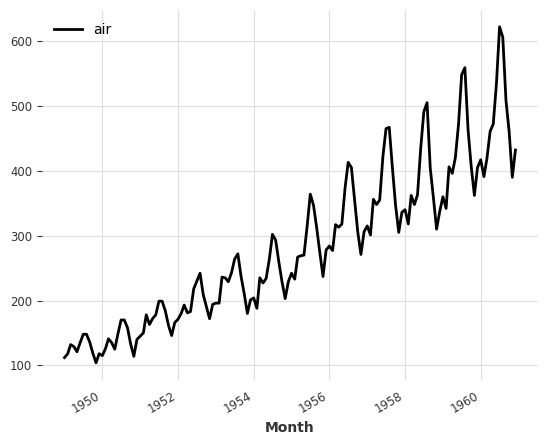

In [3]:
series_air.plot(label="air")
plt.legend()

In [4]:
train_air, test_air = series_air[:-36], series_air[-36:]

Only trend and seasonality - equivalent to using Prophet

In [5]:
model = NeuralProphetDarts()
model.fit(train_air)
preds_simple = model.predict(36)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.741% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 514


  0%|          | 0/107 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.45E-01, min: 4.02E-02


  0%|          | 0/107 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.33E-01, min: 2.84E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.00E-01
Epoch[514/514]: 100%|██████████| 514/514 [00:03<00:00, 137.41it/s, SmoothL1Loss=0.00124, MAE=10.9, RMSE=14.2, Loss=0.000911, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.741% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 88.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 88.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


With auto-regression

In [6]:
model = NeuralProphetDarts(n_lags=36, n_forecasts=36, n_changepoints=20)
model.fit(train_air)
preds_ar = model.predict(36)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.741% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 1000


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.07E-02, min: 2.76E-01


  0%|          | 0/103 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.73E-03, min: 2.25E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.11E-02
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:04<00:00, 210.17it/s, SmoothL1Loss=0.000164, MAE=4, RMSE=5.23, Loss=0.000136, RegLoss=0] 
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.741% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.278% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.278% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (py.warnings._showwarnmsg) - /Users/blazejnowicki/miniconda3/envs/prophet/lib/python3.9/site-packages/neural

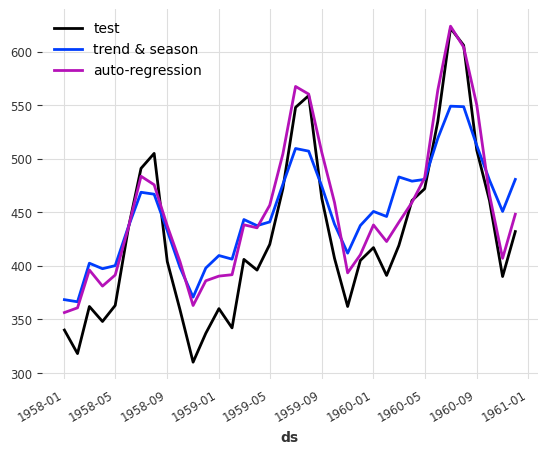

In [7]:
# train_air.plot(label="train")
test_air.plot(label="test")
preds_simple.plot(label="trend & season")
preds_ar.plot(label="auto-regression")

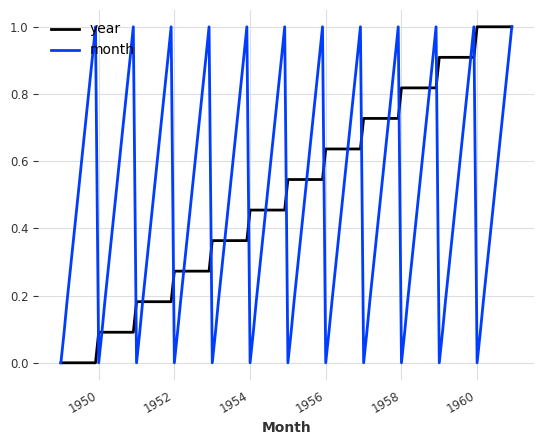

In [9]:
air_year = datetime_attribute_timeseries(series_air, attribute="year")
air_month = datetime_attribute_timeseries(series_air, attribute="month")
air_covariates = air_year.stack(air_month)
scaler = Scaler()
air_covariates = scaler.fit_transform(air_covariates)
air_covariates.plot()